<a href="https://colab.research.google.com/github/Yosolita1978/MyMomAndMe/blob/main/MyMomAndMe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# It's my mom or me? And how much are we alike?


In [1]:
#Install dependencies
! [ -e /content ] && pip install fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.6 MB/s eta 0:00:00
Mounted at /content/gdrive


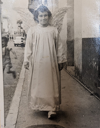

In [2]:
# Testing to see the image
!pip install -q jmd_imagescraper
from pathlib import Path
from jmd_imagescraper.core import *
from fastai.vision.all import *
root = Path().cwd()/"images"
ims = Path('/content/images/mother_teresa/teresa05.jpg')
im = Image.open(ims)
im.to_thumb(128,128)

### Gathering Data

In [36]:
# Track all the images and create a path for each one of them
from os import path
path = Path('images')
fns = get_image_files(path)
fns

(#30) [Path('images/dau_cristina/cristina12.jpg'),Path('images/dau_cristina/cristina13.jpg'),Path('images/dau_cristina/cristina10.jpg'),Path('images/dau_cristina/cristina11.jpg'),Path('images/dau_cristina/cristina01.jpg'),Path('images/dau_cristina/cristina14.jpg'),Path('images/dau_cristina/cristina02.jpg'),Path('images/dau_cristina/cristina15.jpg'),Path('images/dau_cristina/cristina07.jpg'),Path('images/dau_cristina/cristina06.jpg')...]

In [37]:
#Double check that there are not failed images
failed = verify_image(fns)
failed

False

###From Data to DataLoaders

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

* What kinds of data we are working with
* How to get the list of items
* How to label these items
* How to create the validation set


In [44]:
family = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

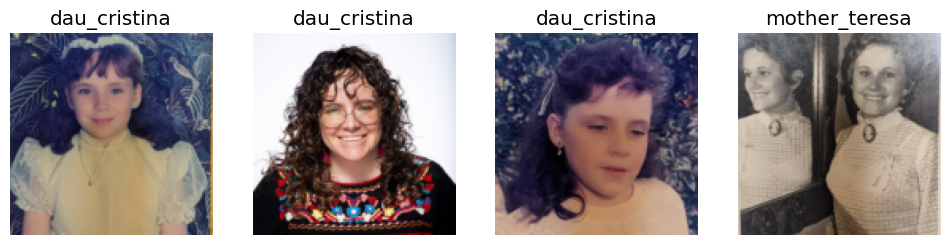

In [45]:
dls = family.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

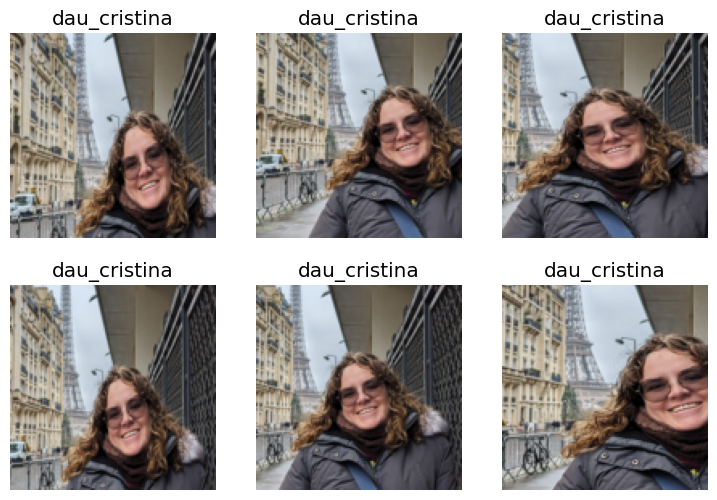

In [49]:
more = family.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = more.dataloaders(path, bs=10)
dls.train.show_batch(nrows=2, ncols=3, unique=True)

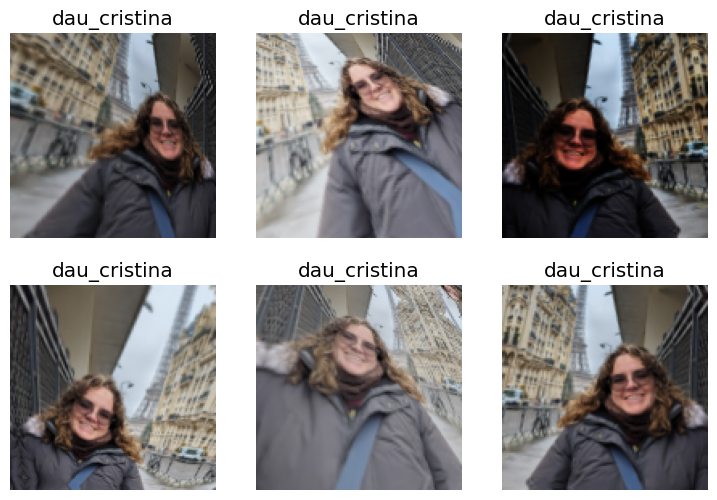

In [48]:
more = family.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = more.dataloaders(path, bs=10)
dls.train.show_batch(nrows=2, ncols=3, unique=True)

In [50]:
more = family.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = more.dataloaders(path)

### Train and Learn

In [51]:
#Create our learn for training
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,nan,2.953531,0.333333,00:00


epoch,train_loss,valid_loss,error_rate,time
0,nan,2.953531,0.333333,00:00
1,nan,2.953531,0.333333,00:00
2,nan,2.953531,0.333333,00:00
3,nan,2.953531,0.333333,00:00


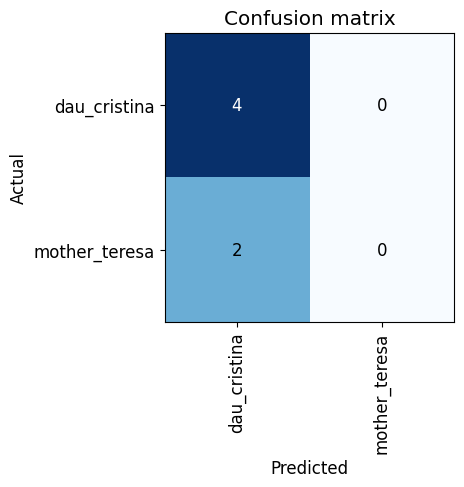

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

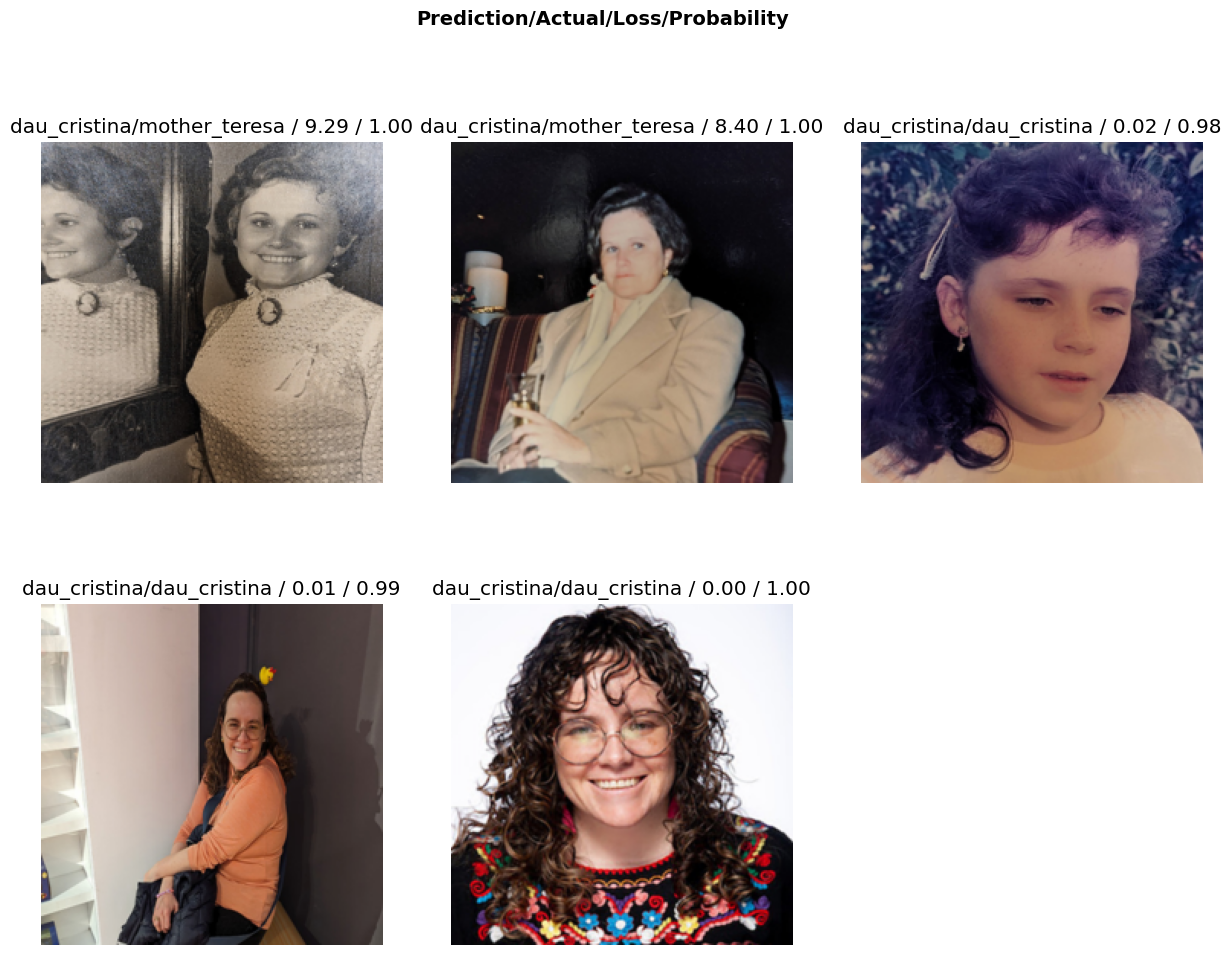

In [53]:
interp.plot_top_losses(5, figsize=(15, 11))

In [54]:
#Checking in what momemt is most confused
interp.most_confused(min_val=2)

[('mother_teresa', 'dau_cristina', 2)]

In [55]:
#Clean the data
cleaner = ImageClassifierCleaner(learn)
cleaner

In [29]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Fine-Tuning my model

For this fine-tuning portion, I'm going to unfreeze the entire model, including the pre-trained layers. Then, I'll train the model for 10 epochs, using a variable learning rate between 0.0001 and 0.001. Finally, I'll save the updated model.

In [56]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10, 1e-2)
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,nan,1.553676,0.333333,00:00


epoch,train_loss,valid_loss,error_rate,time
0,nan,1.553676,0.333333,00:00
1,nan,1.553676,0.333333,00:00
2,nan,1.553676,0.333333,00:00
3,nan,1.553676,0.333333,00:00
4,nan,1.553676,0.333333,00:00
5,nan,1.553676,0.333333,00:00
6,nan,1.553676,0.333333,00:01
7,nan,1.553676,0.333333,00:01
8,nan,1.553676,0.333333,00:01
9,nan,1.553676,0.333333,00:00


# Building a GUI for testing more photos

In [61]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [62]:
img = PILImage.create(btn_upload.data[-1])

In [63]:
# We can use an Output widget to display it:

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl


Output()

In [64]:
#We can get the predictions and labels
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: dau_cristina; Probability: 0.7909')